# RQ1 mutation map

## To what extent the sota benchmark is mutable according to wasm-mutate?


In [1]:
# download datasets
# Set DBPASS DBUSER and DBCONN env var to read from the right mongodb
#!../analyzer/target/debug/analyzer admin admin --collection_name filtered_d0 --dbconn mongodb://localhost:27017 export all.json

#!../analyzer/target/debug/analyzer admin admin --collection_name filtered_d0 --dbconn mongodb://localhost:27017 export filtered.json

!../analyzer/target/debug/analyzer admin admin --collection_name filtered_d2 --dbconn mongodb://localhost:27017 export filtered_d2.json


Exporting


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import json

def load_sets(name, find_mutation_info=False):
    a = open(name, 'r').read()
    data = json.loads(a)
    
    sets = {}
    
    upto=-1
        
    for i, t in enumerate(data[:upto]):
        name = t['id']
        mutations = t['mutations']
        
        
        for m in mutations:            
            if find_mutation_info:
                try:
                    r = []
                    count, file = m['map']
                    # load file
                    f = open(file, "r").read()
                    f = json.loads(f)
                    m['map'] = f
                        
                    if ('Peephole' in m['class_name'] or 'Codemotion' in m['class_name']) and len(m['map']) == 0:
                        continue
                        
                except Exception as e:
                    print(e)
                    break
            
            if m['class_name'] not in sets:
                sets[m['class_name']] = []
            sets[m['class_name']].append(t)

   
    for k, v in sets.items():
        print(k, len(v))
    return list(zip(sets.keys(), sets.values())), len(data[:upto])



    
sets, total = load_sets("all.json", find_mutation_info = False)
print(total)

PeepholeMutator::new(10) 8459
CodemotionMutator 8459
AddTypeMutator { max_params: 20, max_results: 20 } 8460
AddFunctionMutator 8460
RemoveItemMutator(Item::Function) 8459
RemoveItemMutator(Item::Global) 6453
RemoveItemMutator(Item::Memory) 8294
RemoveItemMutator(Item::Table) 7581
RemoveItemMutator(Item::Type) 8460
RemoveSection::Custom 2697
CustomSectionMutator 2697
RemoveSection::Empty 126
8460


In [3]:
# import and set figure size
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]



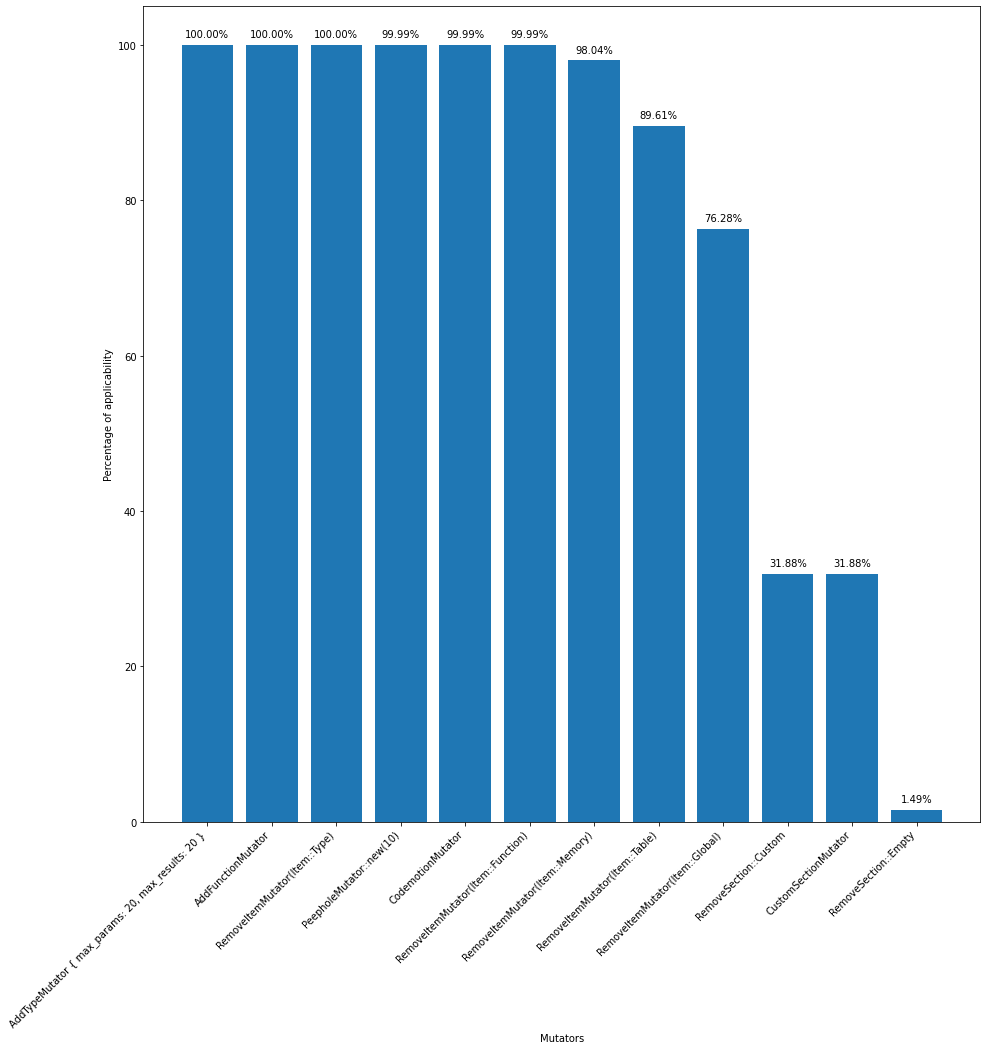

In [4]:
# Plot mutable ratio, for unfiltered dataset

def plot_bars(sets, total):
    bins = [ (k, 100*len(v)/total) for k, v in sets ]
    xs = [ k for k,_ in sets ]

    bins = sorted(bins, key= lambda x: x[1], reverse= True )

    pps = plt.bar([x[0] for x in bins], [x[1] for x in bins])
    for p in pps:
        height = p.get_height()
        plt.text(x=p.get_x() + p.get_width() / 2, y=height+1, s="{:.2f}%".format(height),ha='center')

    plt.xticks(rotation='45',ha='right')
    plt.xlabel("Mutators")
    plt.ylabel("Percentage of applicability")
    
    
plot_bars(sets, total)


### Insights

- A binary can always be mutated by adding a new type definition
- To add a bogus function, the binary needs to have a code section, therefore, only 97.29% of the cases can. The remaining 2.71% of the binaries in the while (unfiltered) has no code section. This is probably due to the presence of test suites
- In 96.59% of the cases a peephole mutator can be applied (the same for the code motion). However, this figure takes into account only the high level validation of the mutator. For example, the code mutator only checks for local defined functions. Thus, we need to go deeper and evaluate how many of the instructions per module (% could be) can be in practice parsed and replaced in the relying egraphs. The same for the code mutator.

- The RemoveSection:Custom can be applied to 62.74% of the binaries. This means, that this mutator can be applied without interfiring with the execution of the binary at all. Usually custom sections only appear to provide debug information, such as function names. This leads us to apply reduce to the dataset to evaluate if in fact even after the manual filtering it still be biased by natural obfuscation.

- On the other hand, some mutation can be applied but the generated module could be invalid and thats how wasm-mutate validates the binary. For example, the remove global mutator can be applied, but only at the validation stage, we could notice if the removed global was used or not.

## Applying the same experiment to already filtered binaries

In [5]:
sets, total = load_sets("filtered.json", find_mutation_info = False)
print(total)

PeepholeMutator::new(10) 8459
CodemotionMutator 8459
AddTypeMutator { max_params: 20, max_results: 20 } 8460
AddFunctionMutator 8460
RemoveItemMutator(Item::Function) 8459
RemoveItemMutator(Item::Global) 6453
RemoveItemMutator(Item::Memory) 8294
RemoveItemMutator(Item::Table) 7581
RemoveItemMutator(Item::Type) 8460
RemoveSection::Custom 2697
CustomSectionMutator 2697
RemoveSection::Empty 126
8460


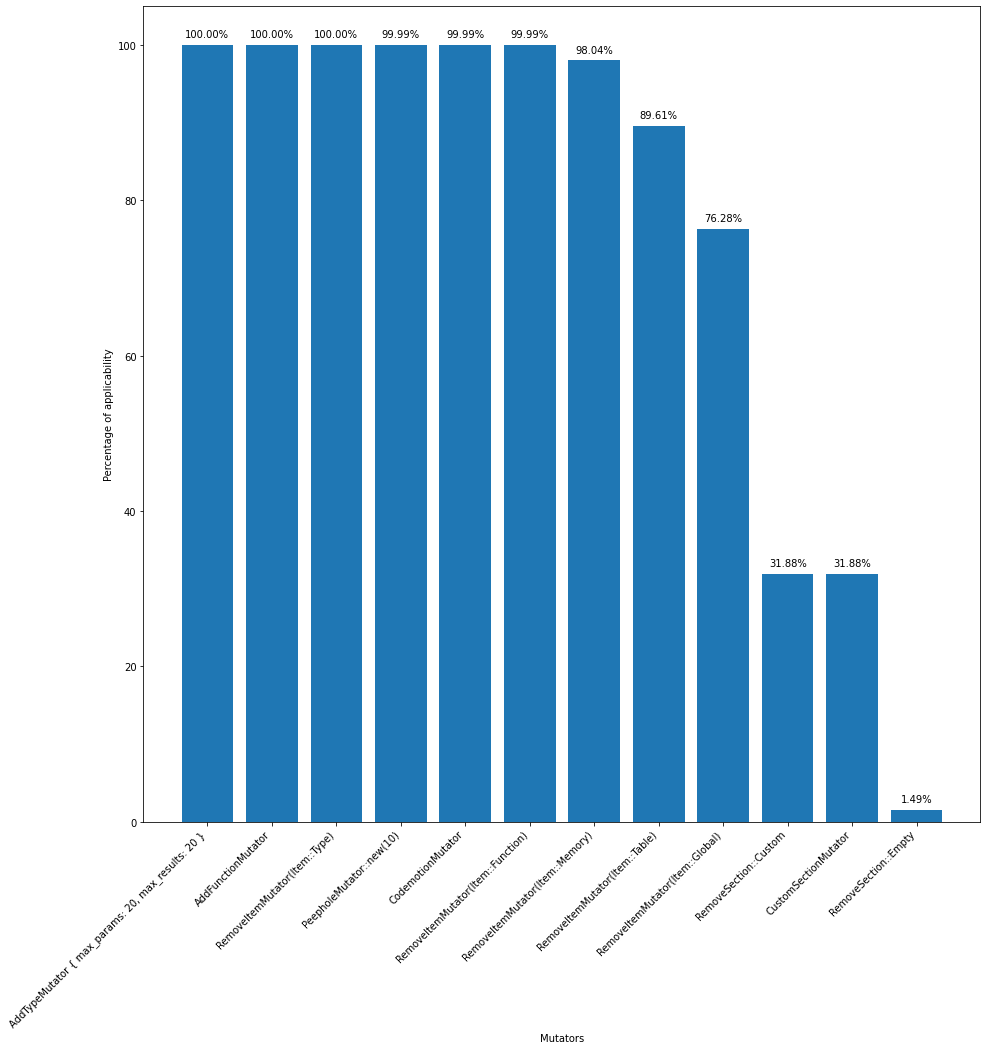

In [6]:
plot_bars(sets, total)

- Interesting, all binaries in the filtered dataset have code section, therefore, we can apply the peephole mutator to all
- Still, RemoveCustomSection can be applied in 32% of the cases. The dataset is probably biased
    - (Insight1)After, some experiments, the reduction works for less than 1% of the cases, therefore the manual filtering is consistent

## Fine-grained checking of mutability

In [7]:
sets, total = load_sets("filtered_d2.json", find_mutation_info = True)
print(len(sets), total)
#print(sets[1][1])

PeepholeMutator::new(10) 178
AddTypeMutator { max_params: 20, max_results: 20 } 178
AddFunctionMutator 178
RemoveItemMutator(Item::Function) 178
RemoveItemMutator(Item::Memory) 175
RemoveItemMutator(Item::Table) 156
RemoveItemMutator(Item::Type) 178
CodemotionMutator 172
RemoveSection::Custom 55
RemoveItemMutator(Item::Global) 127
CustomSectionMutator 55
RemoveSection::Empty 3
12 178


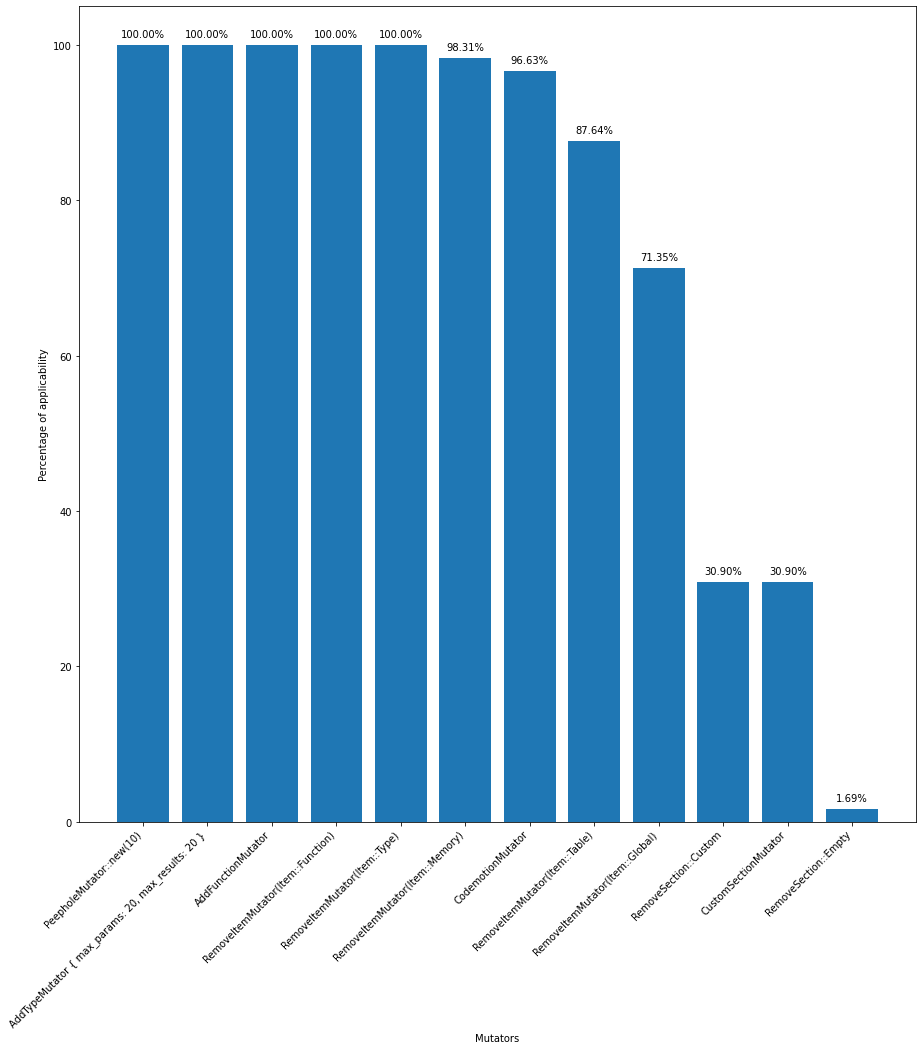

In [8]:
plot_bars(sets, total)

In [ ]:
import numpy as np

peep = sets[0]
randombin = peep[1][0]

print("Id", randombin['id'])

print(randombin['mutations'][0]['class_name'])
# List how the mutation can be applied
print(list(randombin['mutations'][0]['map'].values())[0][0]['how'])

operators_count = randombin['num_instructions']
mutations_count = len(randombin['mutations'][0]['map'].values())
peephole_mutability = mutations_count/operators_count

print(operators_count, mutations_count, peephole_mutability)

# get all posible peephole_mutations for this binary, in this function
def get_mutability(bininfo, key='Peephole'):
    operators_count = bininfo['num_instructions']
    # search the peephole mutation
    for m in bininfo['mutations']:
        if key in m['class_name']:
            if len(m['map']) == 2:
                mutations_count = m['map'][0]
            else:
                mutations_count = len(m['map'])
            break
            
    peephole_mutability = mutations_count/operators_count

    return peephole_mutability


allbins = [  ]

for s in sets:
    if 'Peephole' in s[0]:
        for b in s[1]:
            allbins.append(b)
        
mutabilities = [ get_mutability(b, key='Peephole') for b in allbins ]

print(len(mutabilities))


print("Mutability distribution for the peephole mutator")
plt.hist(mutabilities, bins=100)
plt.xticks(np.arange(0, 1, 0.1))
plt.xticks("Mutability percentage")
plt.yticks("Number of binaries in the class")

The peephole mmutator is able to mutate > ~27% of all instructions int he benchmark. At least 27/100 instructions are mutable in all binaries using the peephole mutator.

## Code motion mutability distribution

172
No mutable at all 0
No mutable loops 2
No mutable ifs 124


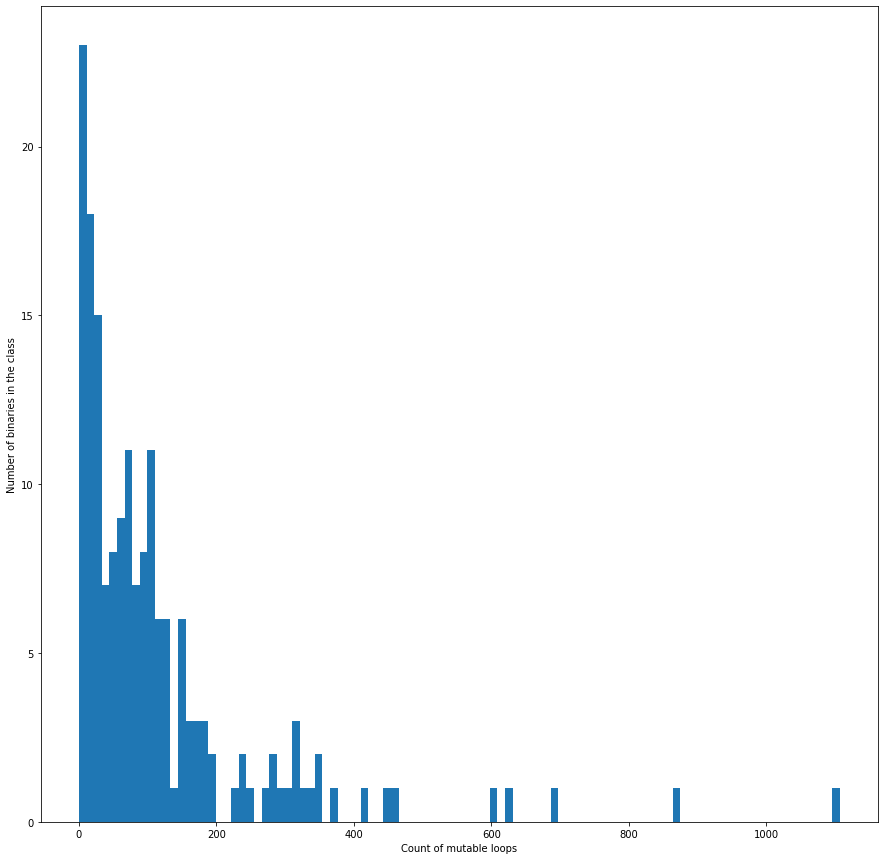

In [10]:
def get_mutable_type_distribution_for_code_motion(bininfo):
    operators_count = bininfo['num_instructions']
    # search the peephole mutation
    loops = 0
    ifs = 0
    
    for m in bininfo['mutations']:
        if 'Codemotion' in m['class_name']:
            for c in m['map'].values():
                for place in c:

                    if 'Invert' in place['how']:
                        ifs += 1
                    if 'Unroll' in place['how']:
                        loops += 1
            break
            
    return loops, ifs


allbins = [  ]

for s in sets:
    if 'Codemotion' in s[0]:
        for b in s[1]:
            allbins.append(b)

mutabilities = [ get_mutable_type_distribution_for_code_motion(b) for b in allbins ]

print(len(mutabilities))
plt.hist([x[0] for x in mutabilities], bins=100)
plt.xlabel("Count of mutable loops")
plt.ylabel("Number of binaries in the class")

print("No mutable at all", len([_ for x in mutabilities if x[0] == 0 and x[1] == 0]))
print("No mutable loops", len([_ for x in mutabilities if x[0] == 0 ]))
print("No mutable ifs", len([_ for x in mutabilities if x[1] == 0 ]))



As expected, there are many more loops than ifs. THe reason is that if constructions are really uncommon un Wasm. Instead, select is used since in the majority of the cases the blocks return a type. **TODO**, check for type returning blocks in all binaries

Text(0, 0.5, 'Number of binaries in the class')

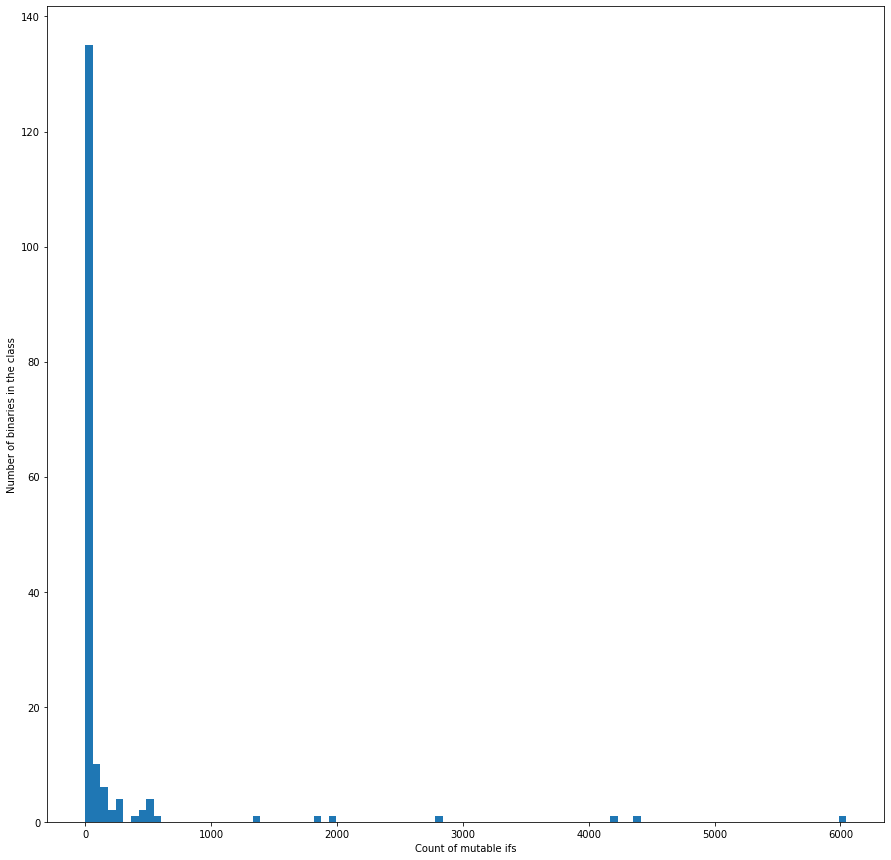

In [11]:

plt.hist([x[1] for x in mutabilities], bins=100)
plt.xlabel("Count of mutable ifs")
plt.ylabel("Number of binaries in the class")

Text(0, 0.5, 'Number of binaries in the class')

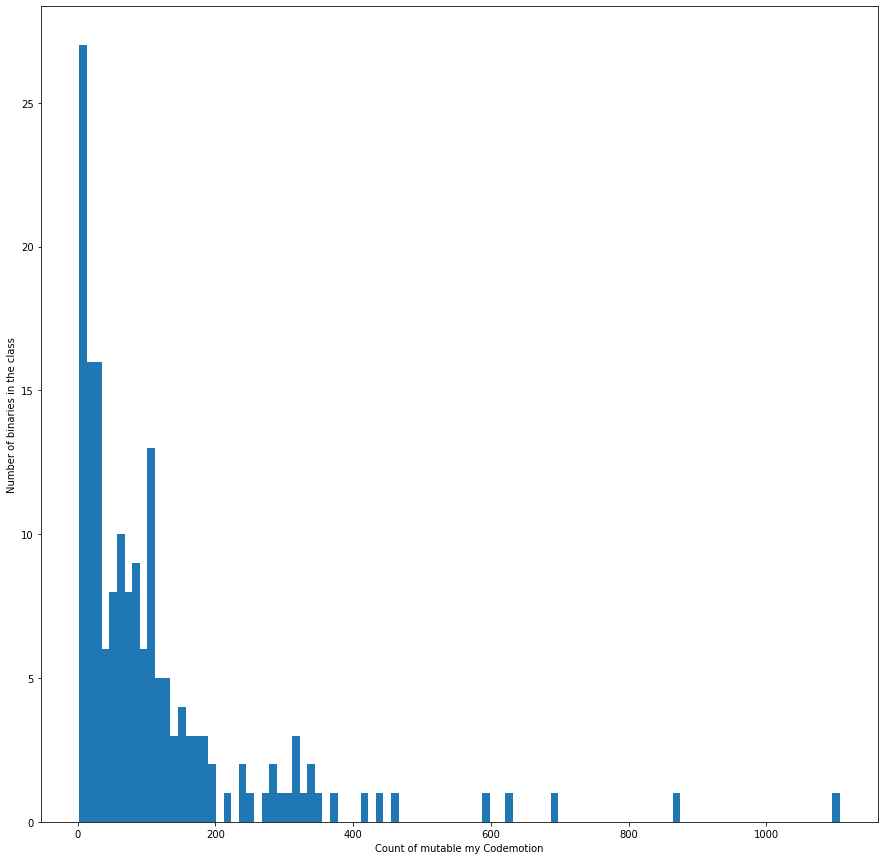

In [12]:

plt.hist([x[0] if x[0] > 0 else x[1] for x in mutabilities], bins=100)
plt.xlabel("Count of mutable my Codemotion")
plt.ylabel("Number of binaries in the class")

## Egraph stats

(array([93.,  8., 17., 26., 16.,  7.,  4.,  3.,  2.,  2.]),
 array([ 10. ,  25.1,  40.2,  55.3,  70.4,  85.5, 100.6, 115.7, 130.8,
        145.9, 161. ]),
 <BarContainer object of 10 artists>)

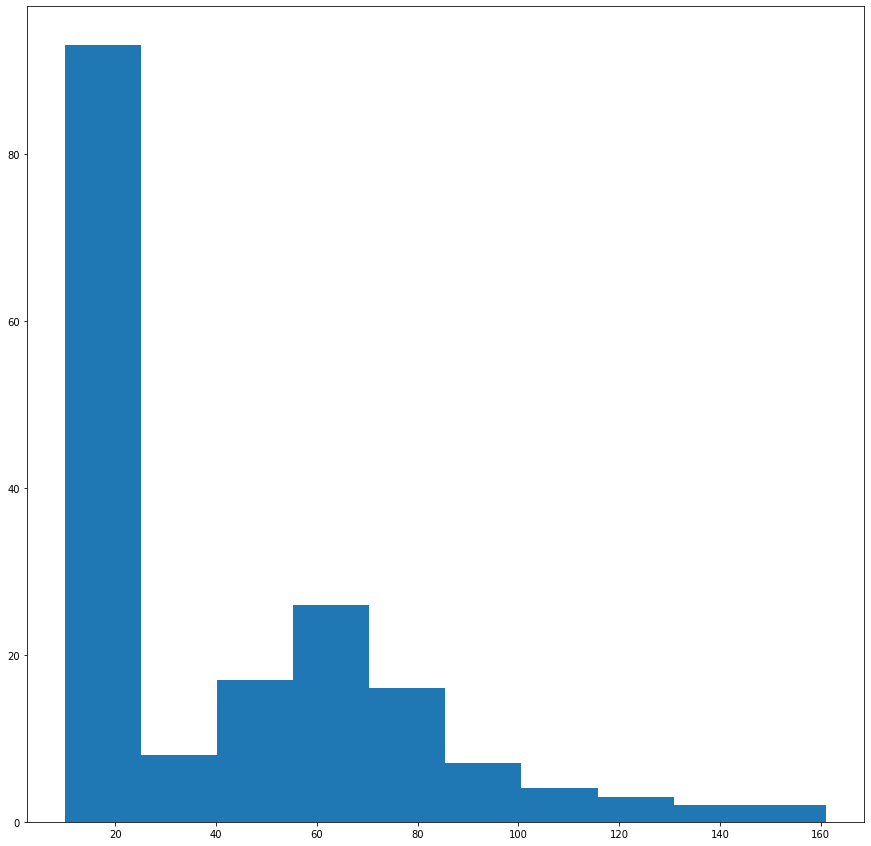

In [13]:
# get some stats on the egraphs of instructions
# get some stats on the profiling of mutable instructions. How many of the specification are we covering ?

# get all posible peephole_mutations for this binary, in this function
def get_egraphs_data(bininfo, key='Peephole'):
    operators_count = bininfo['num_instructions']
    # search the peephole mutation
    egraph_nodes = 0
    egraph_eclasses = 0
    
    for m in bininfo['mutations']:
        if key in m['class_name']:
            if len(m['map']) == 2:
                mutations_count = m['map'][0]
            else:
                for places in m['map'].values():
                    for place in places:
                        # print(place['meta'])
                        egraph_nodes = int(place['meta']['egraph_node_count'])
                        egraph_eclasses = int(place['meta']['egraph_eclass_count'])
            break
            

    return egraph_nodes, egraph_eclasses


allbins = [  ]

for s in sets:
    if 'Peephole' in s[0]:
        for b in s[1]:
            allbins.append(b)
            
egraphs_datas = [ get_egraphs_data(b) for b in allbins ]
xs = sorted([x[0] for x in egraphs_datas])
# Plot distribution of egraph node count
plt.hist(xs)


(array([ 1., 12., 83., 16., 30., 15.,  7.,  4.,  3.,  7.]),
 array([ 5. ,  6.1,  7.2,  8.3,  9.4, 10.5, 11.6, 12.7, 13.8, 14.9, 16. ]),
 <BarContainer object of 10 artists>)

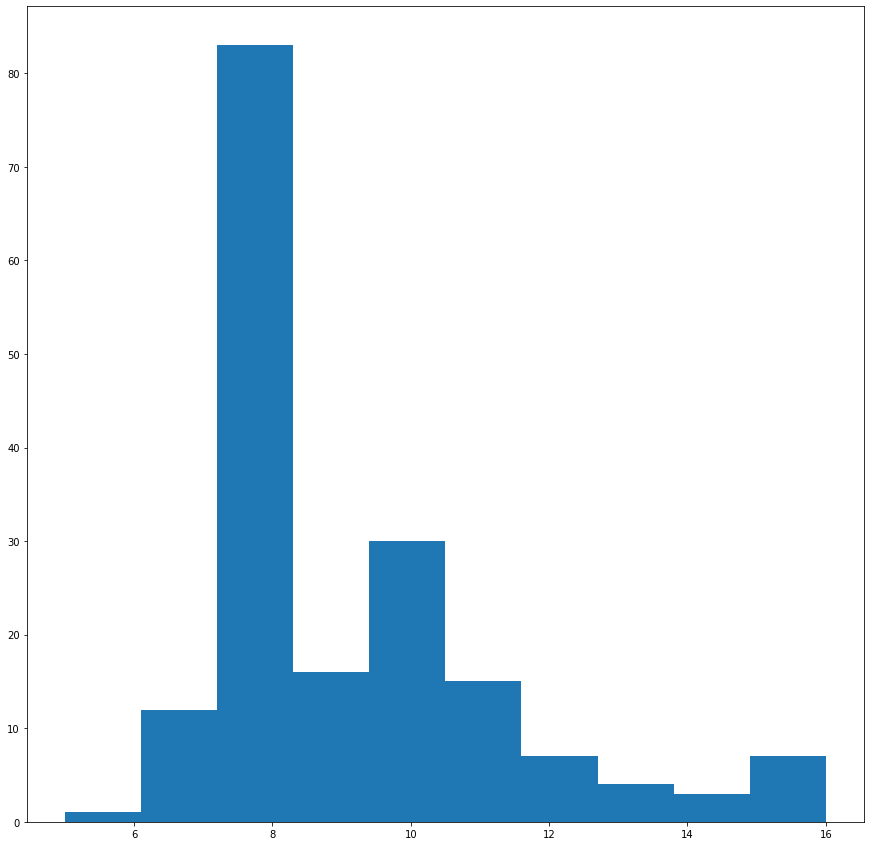

In [14]:

# Plot distribution of egraph eclass count
plt.hist([x[1] for x in egraphs_datas])